In [1]:
import numpy as np
import pandas as pd

import sys, os, time
import glob

from matplotlib import pyplot as plt
%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from skimage.io import imread, imsave

import warnings
warnings.filterwarnings('ignore')

import gzip
import cPickle as pickle
import copy

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable, grad
import torchvision.transforms as transforms

sys.path.append("../models/pytorch-CycleGAN-and-pix2pix/")

from models.models import create_model
from data.data_loader import CreateDataLoader
from util.visualizer import Visualizer
from pdb import set_trace as st
from util import html

sys.path.append("../pytorch_utils")
from loader_dataframe import ImageDataFrame, fn_rotate, grayscale_loader, default_loader

# Define spatial statistics of interest

In [3]:
from skimage import morphology

compute_pct_occupied = lambda img: (img/float(img.max())).sum() / float(img.shape[0]*img.shape[1])

def compute_patch_areas(M):
    mask = morphology.label(M)
    areas = []
    for i in np.arange(1,mask.max()):
        areas.append((i,(mask==i).sum()))
    areas.sort(key=lambda x: x[1], reverse=True)
    return areas, mask

def compute_patch_area_distribution(img, bins=None):
    areas, mask = compute_patch_areas(img)
    area_sizes = [x[1] for x in areas]
    N_counts, bins = np.histogram(area_sizes, bins=bins)
    mask = None; area_sizes = None
    return np.log(N_counts), bins, areas

In [4]:
import scipy.misc

def fractal_dimension(Z, threshold=0.9):

    # Only for 2d image
    assert(len(Z.shape) == 2)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])


    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes[1:]), np.log(counts[:-1]), 1)
    return -coeffs[0], np.log(sizes), np.log(counts)

In [5]:
def compute_stats(img, imgSize=None):
    pct_occupied = compute_pct_occupied(img)
    fd, log_sizes, log_counts = fractal_dimension(img)
    return pct_occupied, fd

# Load model to analyze

In [6]:
def parse_value(v):
    try:
        v = float(v)
        if np.isinf(v):
            return v
        if np.round(v,0)==v:
            v = int(v)
        return v
    except:
        pass

    if v == 'False':
        return False
    elif v == 'True':
        return True
    elif '|' in v:
        v = v.split("|")
    elif v == '[]':
        v = []
    elif '[' in v:
        v = [int(x) if "'" not in x and '"' not in x else x.replace("'","").replace('"',"") \
             for x in v[1:-1].split(", ")]
    else:
        pass
    return v

from collections import namedtuple

def parse_opt_file(filename):
    with open(filename, "r") as f:
        lines = f.readlines()
    lines = [tuple(l.replace("\n","").split(': ')) for l in lines[1:-1]] 
    lines = [(x[0], parse_value(x[1])) for x in lines]
    ret = namedtuple("opt", [l[0].strip() for l in lines])
    for l in lines:
        setattr(ret, l[0], l[1])
    return ret

In [13]:
codebase_path = "/home/nbserver/urbanization-patterns/models/pytorch-CycleGAN-and-pix2pix/"

experiment_path = "pix2pix_reg_bceloss_af_nowater"

In [14]:
opt_filename = codebase_path + "./checkpoints/" + experiment_path + "/opt.txt"

opt = parse_opt_file(opt_filename)
opt.checkpoints_dir = codebase_path + opt.checkpoints_dir
opt.batchSize = 1
if opt.label_columns == "":
    opt.label_columns = []
if hasattr(opt, 'cond_columns') and opt.cond_columns == "":
    opt.cond_columns = []
    
opt.nThreads = 1   # test code only supports nThreads=1
opt.batchSize = 1  #test code only supports batchSize=1
opt.serial_batches = True # no shuffle
# opt.gpu_ids = '-1'
opt.noise_amt = 0.01

In [15]:
df = pd.read_csv(opt.dataroot + "train.csv").drop("Unnamed: 0", 1)
df.head(2)

,filename_SAR,class,country,population,city,region,source,build pct 128,patch distr 128,top patch areas 128,...,box counts 286,build pct 64,patch distr 64,top patch areas 64,fractal dim 64,box counts 64,decile,basename,index,filename_PNM
0,/home/data/world-cities/urban_areas_over_10kpo...,very-small,us,16525,"swansea, us (pop 16.5k)",Americas,SAR,0.064736,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[20.0, 9.0, 6.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0,...",...,"[1.38629436, 2.19722458, 3.17805383, 4.2195077...",0.061183,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[9.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",1.396578,"[0.0, 1.38629436, 2.07944154, 2.99573227, 3.43...",7,"us_swansea,-us-(pop-16.5k)_very-small_16525_41...",12198,/home/data/world-cities/urban_areas_over_10kpo...
1,/home/data/world-cities/urban_areas_over_10kpo...,very-small,de,12299,"niefern oschelbronn, de (pop 12.3k)",Europe,SAR,0.102244,"[0.69314718, 0.0, 0.69314718, 0.0, 0.0, 0.0, 0...","[8.0, 5.0, 5.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, ...",...,"[1.38629436, 2.19722458, 3.21887582, 4.3944491...",0.100213,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.696283,"[0.0, 1.38629436, 2.56494936, 3.52636052, 4.02...",9,"de_niefern-oschelbronn,-de-(pop-12.3k)_very-sm...",11861,/home/data/world-cities/urban_areas_over_10kpo...


In [16]:
df_val = pd.concat([df[(df['city'].str.contains('barcelona')) & (df['country']=='es') & (df['population']>500000)],
                    df[(df['city'].str.contains('san francisco')) & (df['country']=='us') & (df['population']>500000)],
                    df[(df['city'].str.contains('paris')) & (df['country']=='fr') & (df['population']>500000)],
                    df[(df['city'].str.contains('new delhi')) & (df['country']=='in') & (df['population']>500000)],
                    df[(df['city'].str.contains('boston')) & (df['country']=='us') & (df['population']>500000)]])
df_val.to_csv(opt.dataroot + "valid_sample.csv")

In [105]:
df_valid = pd.read_csv(opt.dataroot + "valid.csv").drop("Unnamed: 0", 1)
df_valid.rename(columns={"filename":"filename_SAR"}, inplace=True)
df_valid['filename_PNM'] = df_valid['filename_SAR'].apply(lambda x: x.replace("SAR", "PNM"))
df_valid.to_csv(opt.dataroot + "valid.csv")

In [299]:
opt.phase = 'valid_sample'
data_loader_smpl = CreateDataLoader(opt)
dataset_smpl = data_loader_smpl.load_data()

opt.phase = 'valid'
data_loader_valid = CreateDataLoader(opt)
dataset_valid = data_loader_valid.load_data()

opt.phase = 'train'
data_loader_train = CreateDataLoader(opt)
dataset_train = data_loader_train.load_data()

opt.phase = "test"
data_loader_test = CreateDataLoader(opt)
dataset_test = data_loader_test.load_data()
visualizer = Visualizer(opt)


AlignedDataLoaderCSV
loading from file /home/data/world-cities/top10k-log//valid_sample.csv
AlignedDataLoaderCSV
loading from file /home/data/world-cities/top10k-log//valid.csv
AlignedDataLoaderCSV
loading from file /home/data/world-cities/top10k-log//train.csv
AlignedDataLoaderCSV
loading from file /home/data/world-cities/top10k-log//test.csv
create web directory /home/nbserver/urbanization-patterns/models/pytorch-CycleGAN-and-pix2pix/./checkpoints/pix2pix_reg_bceloss_af_nowater/web...


In [289]:
model = create_model(opt)

model.load_network(model.netD, 'D', 'latest')
model.load_network(model.netG, 'G', 'latest')

pix2pix-reg
---------- Networks initialized -------------
UnetGenerator (
  (model): UnetSkipConnectionBlock (
    (model): Sequential (
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): UnetSkipConnectionBlock (
        (model): Sequential (
          (0): LeakyReLU (0.2, inplace)
          (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
          (2): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
          (3): UnetSkipConnectionBlock (
            (model): Sequential (
              (0): LeakyReLU (0.2, inplace)
              (1): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
              (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
              (3): UnetSkipConnectionBlock (
                (model): Sequential (
                  (0): LeakyReLU (0.2, inplace)
                  (1): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
                  (2

# Compute test stats

In [290]:
stats_df = []

for i, data in enumerate(dataset_train):
    clear_output(wait=True)
    print "%d"%(i)
    
    # perform forward pass using current data
    model.set_input(data)
    model.test()
    
    # extract model results
    imgA_path, imgB_path = model.get_image_paths()
    visuals = model.get_current_visuals()
    imgB_np = copy.copy(visuals['real_B'])
    imgB_np_fake = copy.copy(visuals['fake_B'])
    
    # compute labels of generated images
    labels_fake_true = compute_stats(imgB_np_fake[:,:,0], imgSize=256)
    labels_comp_true = compute_stats(imgB_np[:,:,0], imgSize=256)
    
    # get labels computed by Analyzer
    labels = model.get_current_labels()
    labels_fake_pred = labels['labels_fake'][0]
    labels_real_true = labels['labels']
    
    # add stats to list
    stats_df.append([imgA_path, imgB_path] + \
                    np.hstack([labels_fake_true, labels_fake_pred, labels_comp_true]).tolist())
                 
stats_df = pd.DataFrame(stats_df, 
                        columns=['filenameA', 'filenameB'] + ['a fake', 'f fake'] + 
                                [x+" pred" for x in opt.label_columns] + ['a real', 'f real'])

7931


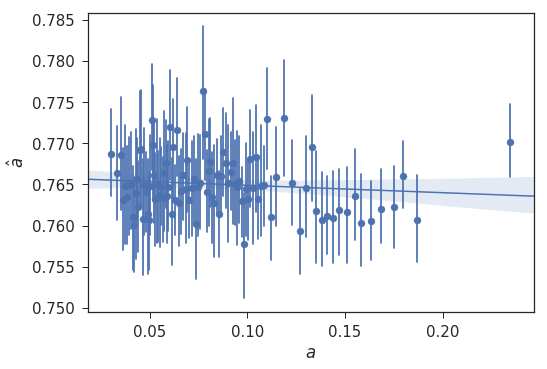

In [291]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})

tips = sns.load_dataset("tips")
ax = sns.regplot(x=stats_df['a real'], y=stats_df['build pct 286 pred'], x_bins=100)
ax.set_xlabel("$a$")
ax.set_ylabel("$\hat a$")

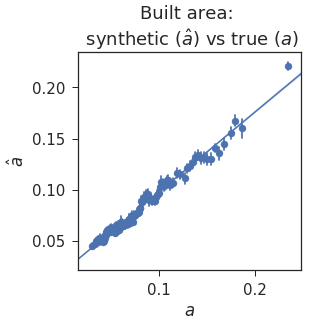

In [292]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})

tips = sns.load_dataset("tips")
plt.figure(figsize=(4,4))
ax = sns.regplot(x=stats_df['a real'], y= stats_df['a fake'], x_bins=100)
ax.set_xlabel("$a$")
ax.set_ylabel("$\hat a$")
ax.set_title("Built area: \n synthetic ($\hat a$) vs true ($a$)")

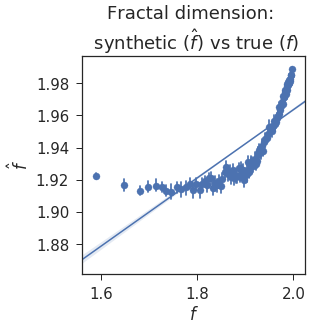

In [293]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})

plt.figure(figsize=(4,4))
tips = sns.load_dataset("tips")
ax = sns.regplot(x=stats_df['f real'], y= stats_df['f fake'], x_bins=100)
ax.set_xlabel("$f$")
ax.set_ylabel("$\hat f$")
ax.set_title("Fractal dimension: \n synthetic ($\hat f$) vs true ($f$)")

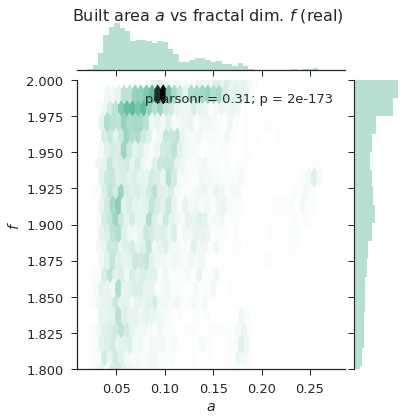

In [294]:
sns.set_context("notebook", font_scale=1.3)

g = sns.jointplot(stats_df['a real'], stats_df['f real'], 
                  ylim=(1.8,2.0),
                  kind="hex", color="#4CB391")
g.fig.suptitle("Built area $a$ vs fractal dim. $f$ (real)", fontsize=16)
g.ax_joint.set_xlabel("$a$")
g.ax_joint.set_ylabel("$f$")

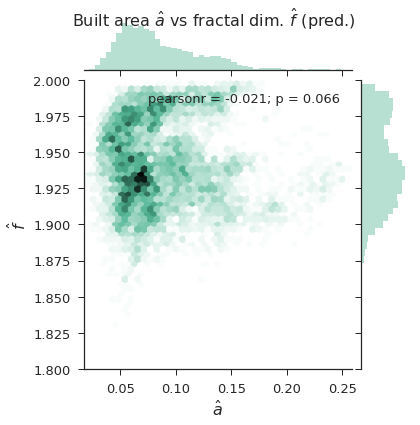

In [295]:
sns.set_context("notebook", font_scale=1.3)

g = sns.jointplot(stats_df['a fake'], stats_df['f fake'], 
                  ylim=(1.8,2.0),
                  kind="hex", color="#4CB391")
g.fig.suptitle("Built area $\hat a$ vs fractal dim. $\hat f$ (pred.)", fontsize=16)
g.ax_joint.set_xlabel("$\hat a$", fontsize=16)
g.ax_joint.set_ylabel("$\hat f$", fontsize=16)

# Scenario analysis

### Look at some examples in detail
Extract gradient information

In [56]:
import copy

def get_regions(img0, patches=[0], c=0, amount=0.0):
    img = copy.copy(img0)
    areas, mask = compute_patch_areas(img)
    to_modify = [areas[p][0] for p in patches]
    mask_sel = np.zeros(mask.shape)
    regions = []
    for m in to_modify:
        mask_sel[mask == m] = 1
        bnds = np.nonzero(mask[:,:,c] == m)
        regions.append(bnds)
    img[:,:,c][mask_sel[:,:,c]>0] *= (1 + amount)
    return img, regions


In [110]:
def extract_rays(img, x0, y0, step=10, n_samples=100):
    n = n_samples / 4
    H,W = img.shape
    x = np.random.randint(0, W, n).tolist() + np.random.randint(0, W, n).tolist() + \
        np.zeros(n).tolist() + np.zeros(n).tolist()
    y = np.zeros(n).tolist() + np.zeros(n).tolist() + \
        np.random.randint(0, H, n).tolist() + np.random.randint(0, H, n).tolist() 
    xy = zip(x, y)
    
    # for each endpoint, extract ray
    theta = []
    rays = []
    rays_binned = np.zeros((len(xy), int(H/step)+1))
    for i,(x1,y1) in enumerate(xy):
        d = np.sqrt((x1-x0)**2 + (y1-y0)**2)
        n_steps = int(np.ceil(d / step))
        ray_x = np.linspace(x0, x1, n_steps)
        ray_y = np.linspace(y0, y1, n_steps)
        r = scipy.ndimage.map_coordinates(img, np.vstack((ray_x, ray_y)))
        t = np.degrees(np.arccos((x1-x0)/float(d)))
        theta.append(t)
        cutoff = min([len(r), int(H/step)+1])
        rays_binned[i,:cutoff] = r[:cutoff]
    
    return theta, rays_binned

In [88]:
theta, ray_bins = extract_rays(grad_pop, 30,40)

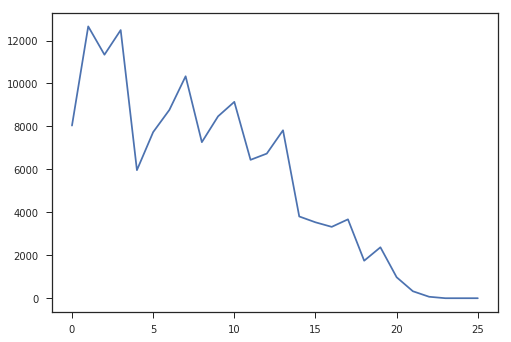

In [89]:
plt.plot(np.abs(ray_bins).mean(0))

In [301]:
info_df

,Unnamed: 0,filename_SAR,class,country,population,city,region,source,build pct 128,patch distr 128,...,box counts 286,build pct 64,patch distr 64,top patch areas 64,fractal dim 64,box counts 64,decile,basename,index,filename_PNM
0,3530,/home/data/world-cities/urban_areas_over_10kpo...,large,es,1570378,"barcelona, es (pop 1.6M)",Europe,SAR,0.033536,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[1.38629436, 2.19722458, 3.04452244, 4.0430512...",0.035099,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.973697,"[0.0, 1.09861229, 1.60943791, 2.07944154, 2.77...",6,"es_barcelona,-es-(pop-1.6M)_large_1570378_41.3...",19218,/home/data/world-cities/urban_areas_over_10kpo...
1,4978,/home/data/world-cities/urban_areas_over_10kpo...,medium,us,732072,"san francisco, us (pop 732.1k)",Americas,SAR,0.085586,"[1.60943791, 1.79175947, 0.69314718, 1.0986122...",...,"[1.38629436, 2.07944154, 2.94443898, 4.0253516...",0.083898,"[1.38629436, 0.0, 0.0, 0.0, 0.0, 0.69314718, 0...","[27.0, 16.0, 7.0, 6.0, 4.0, 3.0, 3.0, 3.0, 3.0...",1.618010,"[0.0, 1.38629436, 2.39789527, 3.40119738, 4.09...",9,"us_san-francisco,-us-(pop-732.1k)_medium_73207...",7668,/home/data/world-cities/urban_areas_over_10kpo...
2,7716,/home/data/world-cities/urban_areas_over_10kpo...,very-large,fr,2110694,"paris, fr (pop 2.1M)",Europe,SAR,0.088579,"[0.69314718, 0.0, 0.0, 0.69314718, 0.0, 0.0, 0...",...,"[1.38629436, 2.19722458, 3.21887582, 4.3944491...",0.087215,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[41.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",1.527113,"[0.0, 1.38629436, 2.56494936, 3.13549422, 3.63...",8,"fr_paris,-fr-(pop-2.1M)_very-large_2110694_48....",1873,/home/data/world-cities/urban_areas_over_10kpo...
3,1543,/home/data/world-cities/urban_areas_over_10kpo...,megalopolis,in,10928270,"new delhi, in (pop 10.9M)",Asia,SAR,0.073842,"[1.60943791, 1.60943791, 0.69314718, 0.0, 0.0,...",...,"[1.38629436, 2.19722458, 3.21887582, 4.3944491...",0.072928,"[0.0, 0.0, 1.38629436, 0.0, 0.0, 0.0, 0.0, 0.0...","[13.0, 4.0, 4.0, 4.0, 4.0, 2.0, 2.0, 1.0, 1.0,...",1.420321,"[0.0, 1.38629436, 2.39789527, 2.94443898, 3.43...",8,"in_new-delhi,-in-(pop-10.9M)_megalopolis_10928...",11691,/home/data/world-cities/urban_areas_over_10kpo...
4,5592,/home/data/world-cities/urban_areas_over_10kpo...,medium,us,571281,"boston, us (pop 571.3k)",Americas,SAR,0.069852,"[1.60943791, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",...,"[1.38629436, 2.19722458, 3.21887582, 4.2484952...",0.072073,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[11.0, 3.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",1.449888,"[0.0, 1.38629436, 2.30258509, 3.04452244, 3.52...",7,"us_boston,-us-(pop-571.3k)_medium_571281_42.35...",241,/home/data/world-cities/urban_areas_over_10kpo...


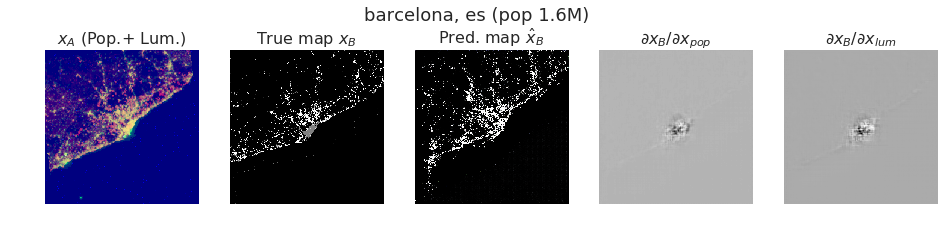

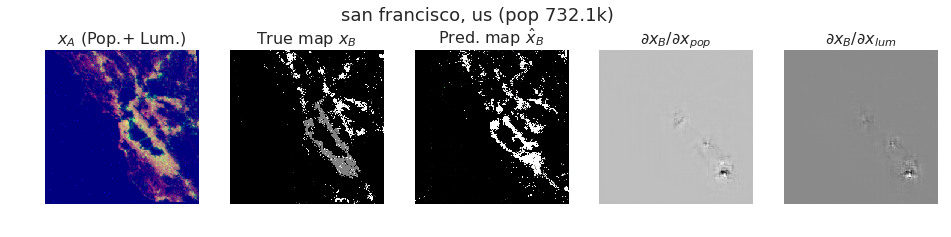

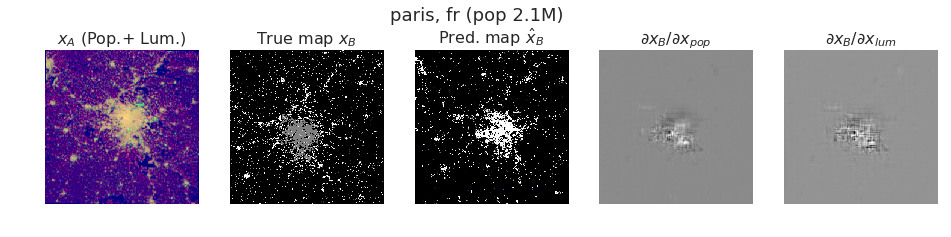

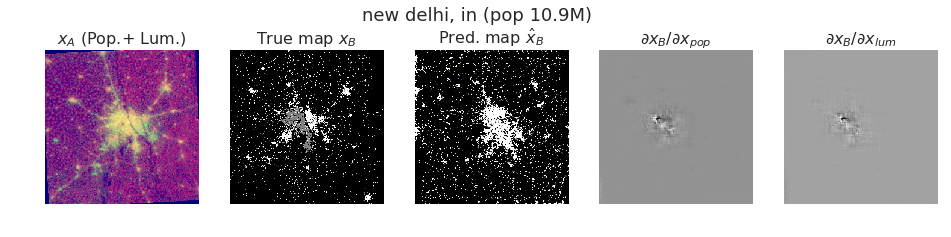

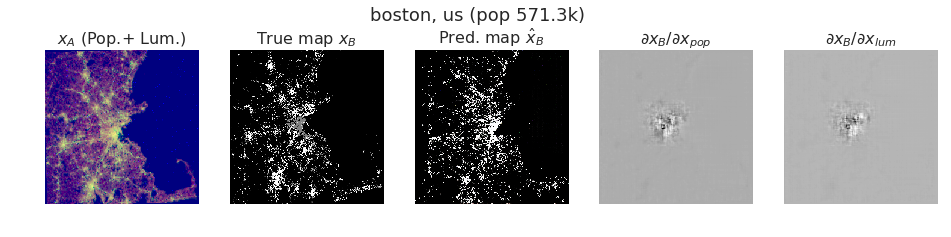

In [303]:
import timeit

which_dataset = dataset_smpl
info_filename = data_loader_smpl.filename_csv
info_df = pd.read_csv(info_filename)

patches = [0] # main urban core
# patches = [1,2,3] # top 2 connected settlements

SHOW_PLOTS = True
N_GRAD_SMPL= 30

scenario_stats = []
grad_dist_pop = []
grad_dist_lum = []

start = timeit.default_timer()
for i, data in enumerate(which_dataset):
    if not SHOW_PLOTS:
        clear_output(wait=True)
        stop = timeit.default_timer()
        print "%d: %2.2f sec"%(i, stop-start)
        start = timeit.default_timer()

    AtoB = model.opt.which_direction == 'AtoB'
    imgA = data['A' if AtoB else 'B']
    imgB = data['B' if AtoB else 'A']
    path = data['A_paths' if AtoB else 'B_paths'][0]
    city_name = os.path.basename(path[0]).split("_")[2].replace("-", " ")
    info = info_df.iloc[i]
    
    if info['build pct 286'] < 0.02:
        continue
    
    # get patches for which to compute average gradient
    imgB_np = imgB.numpy()[0].transpose([1,2,0])
    imgB_np = (imgB_np+1)/(imgB_np.max()+1.0) * 255
    areas, mask = compute_patch_areas(imgB_np)
    _, regions = get_regions(imgB_np, patches=patches)
    
    region_x = []
    region_y = []
    for r in regions:
        region_x.append(r[0])
        region_y.append(r[1])
    region_x = np.hstack(region_x)
    region_y = np.hstack(region_y)
    idx      = np.random.choice(len(region_x), replace=False, 
                                size=min([len(region_x),N_GRAD_SMPL]))
    region   = (region_x[idx], region_y[idx])

    # run model, compute prediction and gradient
    model.set_input(data)
    img_path = model.get_image_paths()
    model.test()
    labels = model.get_current_labels()
    mygrad = model.compute_gradient(region=region)
    mygrad_np = mygrad.numpy()[0].transpose([1,2,0])
    
    # format images for display
    visuals = model.get_current_visuals()
    imgA_np = copy.copy(visuals['real_A'])
    imgB_np = copy.copy(visuals['real_B'])
    imgB_np_fake = copy.copy(visuals['fake_B'])
    
    grad_pop = mygrad_np[:,:,0]/ np.abs(mygrad_np[:,:,0]).min()
    grad_lum = mygrad_np[:,:,1]/ np.abs(mygrad_np[:,:,1]).min()

    # apply mask to regions of interest
    mymask = np.zeros(mask.shape)
    for i,p in enumerate(patches):
        a = areas[p]
        mymask[mask==a[0]] = i+1
    imgB_np[mymask>0] = 128
    
    # compute gradient within/without regions of interest
    norm_grad_pop_within  = np.abs(grad_pop[mymask[:,:,0]>0]).mean()
    norm_grad_pop_without = np.abs(grad_pop[mymask[:,:,0]==0]).mean()
    norm_grad_lum_within  = np.abs(grad_lum[mymask[:,:,0]>0]).mean()
    norm_grad_lum_without = np.abs(grad_lum[mymask[:,:,0]==0]).mean()
    scenario_stats.append((city_name, info['region'], 
                           norm_grad_pop_without/(norm_grad_pop_within+norm_grad_pop_without), 
                           norm_grad_lum_without/(norm_grad_lum_within+norm_grad_lum_without)))
    
    # sample gradient magnitude along random rays to study dependence with distance
    x0, y0 = regions[0][0].mean(), regions[0][1].mean()
    theta_pop, rays_pop = extract_rays(grad_pop, x0, y0, step=10, n_samples=100)
    theta_lum, rays_lum = extract_rays(grad_lum, x0, y0, step=10, n_samples=100)
    rays_pop = np.abs(rays_pop).mean(0); rays_pop = rays_pop / rays_pop.max()
    rays_lum = np.abs(rays_lum).mean(0); rays_lum = rays_lum / rays_lum.max()
    grad_dist_pop.append(rays_pop)
    grad_dist_lum.append(rays_lum)
    
    if SHOW_PLOTS:
        fig, ax = plt.subplots(1,5, figsize=(16,4))

        ax[0].imshow(imgA_np)
        ax[1].imshow(imgB_np)
        ax[2].imshow(imgB_np_fake)
        ax[3].imshow(grad_pop)
        ax[4].imshow(grad_lum)

        titles = ["$x_A$ (Pop.+ Lum.)", "True map $x_B$", "Pred. map $\hat x_B$", 
                  "$\partial x_B/\partial x_{pop}$", "$\partial x_B/\partial x_{lum}$"]
        for i in range(5):
            ax[i].set_title(titles[i],  fontsize=16)
            ax[i].axis("off")

        fig.suptitle(city_name, fontsize=18)
        plt.subplots_adjust(top=1.0)
        plt.show()

scenario_stats = pd.DataFrame(scenario_stats, 
                              columns=["city", "region", "pct grad pop without", "pct grad lum without"])
grad_dist_pop = np.vstack(grad_dist_pop)
grad_dist_lum = np.vstack(grad_dist_lum)

In [297]:
with gzip.open("stats.pickle.gz", "w") as f:
    pickle.dump([grad_dist_pop, grad_dist_lum, scenario_stats],f)

### Distribution of gradient magnitude within/without selected patches

In [133]:
scenario_stats.dropna(inplace=True)
scenario_stats.head(3)

,city,region,pct grad pop without,pct grad lum without
0,"pittsfield, us (pop 44.2k)",Americas,0.044896,0.039249
2,"elesbao veloso, br (pop 10.4k)",Americas,0.069173,0.123400
3,"kastamonu, tr (pop 70.4k)",Asia,0.133330,0.130065


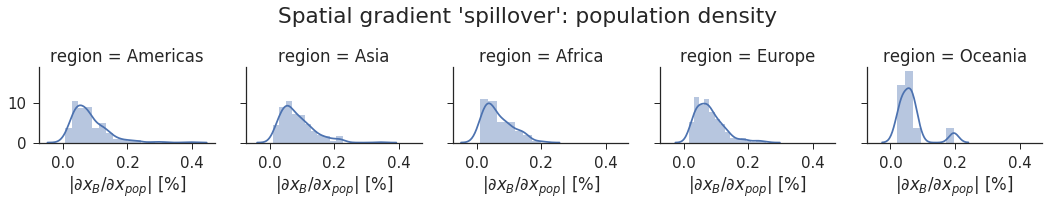

In [157]:
sns.set_context("notebook", font_scale=1.5)
g = sns.FacetGrid(scenario_stats.rename(columns={"pct grad pop without":"$|\partial x_B/\partial x_{pop}|$ [%]"}),
                  col="region", margin_titles=True, sharey=True)
g.map(sns.distplot, "$|\partial x_B/\partial x_{pop}|$ [%]")
plt.subplots_adjust(top=0.7)
g.fig.suptitle("Spatial gradient 'spillover': population density")

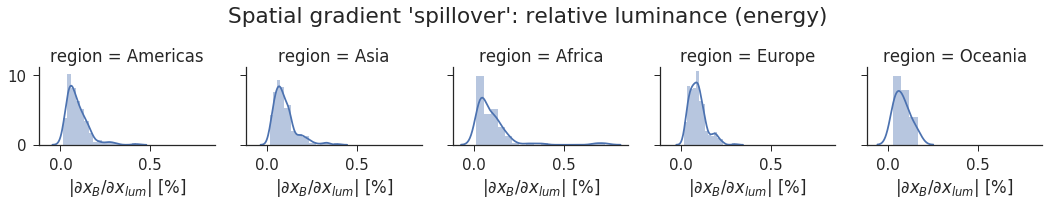

In [158]:
sns.set_context("notebook", font_scale=1.5)
g = sns.FacetGrid(scenario_stats.rename(columns={"pct grad lum without":"$|\partial x_B/\partial x_{lum}|$ [%]"}),
                  col="region", margin_titles=True, sharey=True)
g.map(sns.distplot, "$|\partial x_B/\partial x_{lum}|$ [%]")
plt.subplots_adjust(top=0.7)
g.fig.suptitle("Spatial gradient 'spillover': relative luminance (energy)")

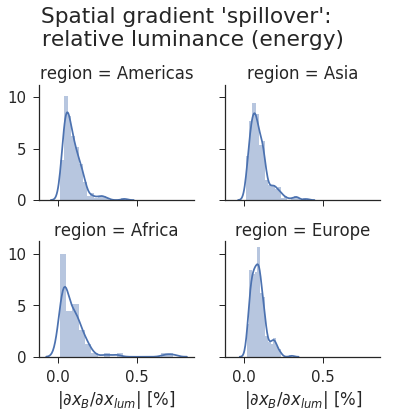

In [284]:
sns.set_context("notebook", font_scale=1.5)
g = sns.FacetGrid(scenario_stats[scenario_stats['region']!='Oceania']\
                      .rename(columns={"pct grad lum without":"$|\partial x_B/\partial x_{lum}|$ [%]"}),
                  col="region", col_wrap=2, margin_titles=True, sharey=True)
g.map(sns.distplot, "$|\partial x_B/\partial x_{lum}|$ [%]")
plt.subplots_adjust(top=0.8)
g.fig.suptitle("Spatial gradient 'spillover': \n relative luminance (energy)")

### Study gradient dependence with distance from patch

In [160]:
scenario_stats.head(3)

,city,region,pct grad pop without,pct grad lum without
0,"pittsfield, us (pop 44.2k)",Americas,0.044896,0.039249
2,"elesbao veloso, br (pop 10.4k)",Americas,0.069173,0.123400
3,"kastamonu, tr (pop 70.4k)",Asia,0.133330,0.130065


In [216]:
idx_ok = ~np.isnan(grad_dist_pop.sum(1))
grad_dist_pop_df = pd.concat([scenario_stats[['city', 'region']], 
                              pd.DataFrame(grad_dist_pop[idx_ok,:])], 1).dropna()

idx_ok = ~np.isnan(grad_dist_lum.sum(1))
grad_dist_lum_df = pd.concat([scenario_stats[['city', 'region']], 
                              pd.DataFrame(grad_dist_lum[idx_ok,:])], 1).dropna()

In [239]:
paris_pop_dist = grad_dist_pop_df[grad_dist_pop_df['city'].str.contains("paris, fr ")]
paris_lum_dist = grad_dist_lum_df[grad_dist_lum_df['city'].str.contains("paris, fr ")]


array([ 0.])

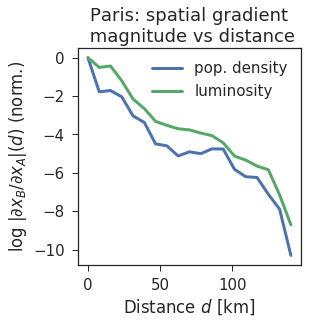

In [264]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})

plt.figure(figsize=(4,4))
plt.plot(np.arange(paris_lum_dist.shape[1]-2)*(10*200.0/256), 
         np.log(paris_pop_dist.drop(["city", "region"],1).values.T), 
         label="pop. density", lw=3)
plt.plot(np.arange(paris_lum_dist.shape[1]-2)*(10*200.0/256), 
         np.log(paris_lum_dist.drop(["city", "region"],1).values.T), 
         label="luminosity", lw=3)
plt.legend()
plt.ylabel("log $|\partial x_B/\partial x_A|(d)$ (norm.)")
plt.xlabel("Distance $d$ [km]")
plt.title("Paris: spatial gradient\n magnitude vs distance")

In [265]:
grad_dist_pop_df_mlt.head()

,region,city,variable,value
0,Americas,"pittsfield, us (pop 44.2k)",0,0.558276
1,Americas,"elesbao veloso, br (pop 10.4k)",0,0.192917
2,Asia,"kastamonu, tr (pop 70.4k)",0,1.000000
3,Asia,"hungund, in (pop 19.0k)",0,1.000000
4,Americas,"fernandez, mx (pop 29.7k)",0,0.034179


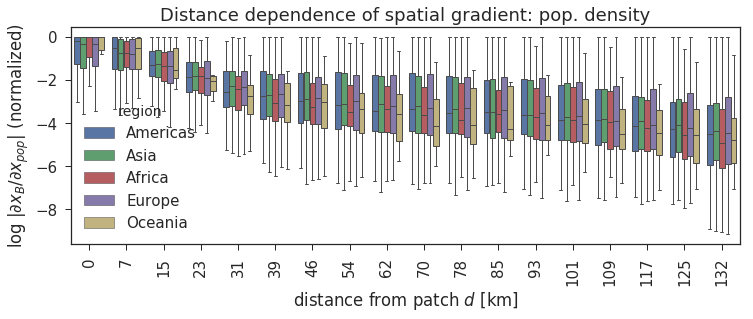

In [273]:
grad_dist_pop_df_mlt = pd.melt(grad_dist_pop_df.iloc[:,:20], 
                               id_vars=["region", "city"])
grad_dist_pop_df_mlt['log value'] = grad_dist_pop_df_mlt['value'].apply(np.log)

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})

plt.figure(figsize=(12,4))
g = sns.boxplot(data=grad_dist_pop_df_mlt, hue="region",
                y="log value", x="variable", showfliers=False)
_ = g.set_xticklabels(((10*200./256)*np.arange(20)).astype(int), 
                      rotation=90)
g.set_xlabel("distance from patch $d$ [km]")
g.set_ylabel("log $|\partial x_B/\partial x_{pop}|$ (normalized)")
g.set_title("Distance dependence of spatial gradient: pop. density")

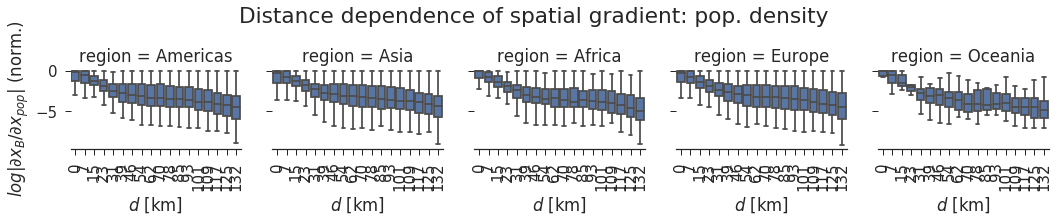

In [274]:
sns.set_context("notebook", font_scale=1.5)

plt.figure(figsize=(16,6))
g = sns.FacetGrid(grad_dist_pop_df_mlt, col="region", 
                  margin_titles=True, sharey=True)
g.map(sns.boxplot, "variable", "log value", showfliers=False)\
    .despine(left=True)
_ = g.set_xticklabels(((10*200./256)*np.arange(26)).astype(int), 
                      rotation=90)
g.set_xlabels("$d$ [km]")
g.set_ylabels("$log |\partial x_B/\partial x_{pop}|$ (norm.)")
g.fig.suptitle("Distance dependence of spatial gradient: pop. density")
plt.subplots_adjust(top=0.7)


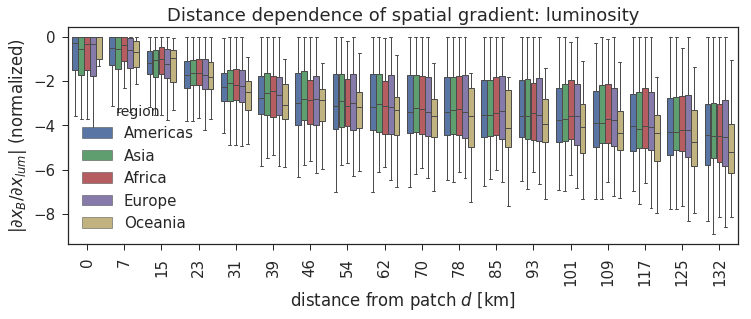

In [280]:
grad_dist_lum_df_mlt = pd.melt(grad_dist_lum_df.iloc[:,:20], 
                               id_vars=["region", "city"])
grad_dist_lum_df_mlt['log value'] = grad_dist_lum_df_mlt['value'].apply(np.log)

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})

plt.figure(figsize=(12,4))
g = sns.boxplot(data=grad_dist_lum_df_mlt, hue="region",
                y="log value", x="variable", showfliers=False)
_ = g.set_xticklabels(((10*200./256)*np.arange(20)).astype(int), 
                      rotation=90)
g.set_xlabel("distance from patch $d$ [km]")
g.set_ylabel("$|\partial x_B/\partial x_{lum}|$ (normalized)")
g.set_title("Distance dependence of spatial gradient: luminosity")

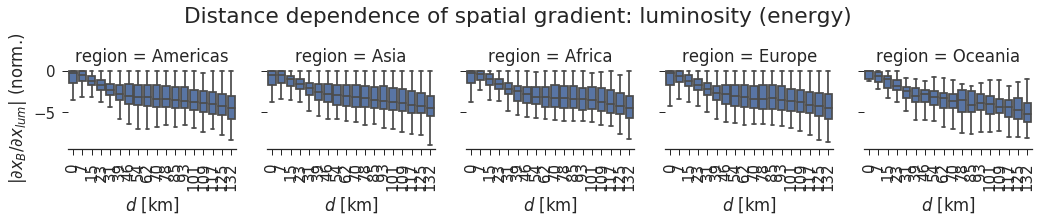

In [279]:
sns.set_context("notebook", font_scale=1.5)

plt.figure(figsize=(16,6))
g = sns.FacetGrid(grad_dist_lum_df_mlt, col="region", 
                  margin_titles=True, sharey=True)
g.map(sns.boxplot, "variable", "log value", showfliers=False)\
    .despine(left=True)
_ = g.set_xticklabels(((10*200./256)*np.arange(26)).astype(int), 
                      rotation=90)
g.set_xlabels("$d$ [km]")
g.set_ylabels("$|\partial x_B/\partial x_{lum}|$ (norm.)")
g.fig.suptitle("Distance dependence of spatial gradient: luminosity (energy)")
plt.subplots_adjust(top=0.7)


# Scratch

In [ ]:
df = pd.read_csv(opt.dataroot + "train.csv").drop("Unnamed: 0", 1)
df.head(2)

In [ ]:
sample = df[(df['city'].str.contains('paris')) & (df['country']=='fr')].iloc[0]

img_A = default_loader(sample['filename_PNM'])
img_A = img_A.resize((opt.fineSize, opt.fineSize))

img_B = default_loader(sample['filename_SAR'])
img_B = img_B.resize((opt.fineSize, opt.fineSize))

In [ ]:
transf_list = [
               transforms.Scale(opt.loadSize),
               transforms.RandomCrop(opt.fineSize)]
if opt.rotate != 0:
    transf_list += [
               transforms.Lambda(lambda img:fn_rotate(img,opt.rotate))]
transf_list += [
               transforms.ToTensor(),
               transforms.Normalize((0.5, 0.5, 0.5),
                                    (0.5, 0.5, 0.5))]
transform = transforms.Compose(transf_list)


In [ ]:
img_A_v = transform(img_A)
img_A_v = img_A_v.resize_((1,) + img_A_v.size())

img_B_v = transform(img_B)
img_B_v = img_B_v.resize_((1,) + img_B_v.size())

model.set_input({'A':img_A_v, 
                 'B':img_B_v, 
                 'A_paths':sample['filename_PNM'], 
                 'B_paths':sample['filename_SAR']})

In [ ]:
model.forward()

In [ ]:
img_fake = model.fake_B.cpu().data.numpy()[0].transpose([1,2,0])

fig, ax = plt.subplots(1,3, figsize=(10,4))
ax[0].imshow(np.array(img_A)); ax[0].set_title("Input domain A")
ax[1].imshow(np.array(img_B)); ax[1].set_title("Target domain B")
ax[2].imshow(img_fake); ax[2].set_title("Generated built map"); ax[0].axis("off")
fig.suptitle(sample['city'], fontsize=18)
plt.subplots_adjust(top=0.9)
ax[0].axis("off"); ax[1].axis("off"); ax[2].axis("off")


In [ ]:
ones = torch.ones(model.real_A.size())
ones.size()

In [ ]:
model.fake_B.backward(gradient=ones, retain_variables=True)

In [ ]:
dXb_dXa = model.real_A.grad
dXb_dXa_np = dXb_dXa.cpu().data.numpy()[0].transpose([1,2,0])

In [ ]:
nc = dXb_dXa_np.shape[2]
var_names = ["population", "nightlights", "water mask"]

fig, ax = plt.subplots(1,2, figsize=(8,6))
for i in range(2):
    img = dXb_dXa_np[:,:,i] / np.abs(dXb_dXa_np[:,:,i]).max()
    ax[i].imshow(img)
    ax[i].set_title(var_names[i])
    ax[i].axis("off")

In [ ]:
from torch.autograd import Variable, grad
import torch

x = Variable(torch.ones(1), requires_grad=True)
y = x.pow(3)

g = grad(y, x, create_graph=True)
print(g) # g = 3

g2 = grad(g, x)
print(g2) # g2 = 6

In [ ]:
tuple(torch.randn((1,2,4)).size())

In [ ]:
z = torch.randn((1,3,4,4))
size = list(tuple(z.size()))
size[1] = 1

In [ ]:
size

In [ ]:
z[:,1,:,:] = torch.randn(size)